In [18]:
import igor.igorpy as igor
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def getPeaks(voltage,tiempo, threshold):
    """Calculates the peaks of a signal, using the second derivative method. 
    It first obtain the positive derivative, then it converts the signal to a 
    discretized format, where the positive derivates will be 1, the negatives
    will be 0.Then, the second derivative is calculated, and the zero crossing
    points are obtained.
    Finally, the points which are greater than threshold are selected and returned.
    Input:
    ----------
    voltage : array
        Voltage trace in which will the peaks will be obtained.
    tiempo: array
        time vector
    threshold: float
        value that will define the peaks bigger that threshold
    Output:
    ---------
    Y: array
         time and the amplitude of each peak"""
    
    dv=np.diff(voltage)
    c=(np.abs(dv>0)).nonzero()[0] #get the positive derivative, ie, the positive slope

    signal = np.ones(len(voltage)) 
    signal[c] = 0  #reconstruct the signal with the positive slopes. 1 if is positive, 0 if not
    b = np.diff(signal)*0.5 #get the changes from positive to negative, ie, peak detection
    peak = [np.where(b==0.5)][0]
    times = tiempo[peak]#[0]
    value = voltage[peak]#[0]
    #t = tiempo[np.where(voltage[peak]>threshold)[0]]
    #v = voltage[np.where(voltage[peak]>threshold)[0]]
    #position = np.where(voltage[[np.where(np.diff(signal)*0.5==0.5)][0]]>threshold)[0]
    v = value[np.where(value>threshold)[0]]
    t = times[np.where(value>threshold)[0]]
    #position = np.where(np.isin(time,t)*1)
    Y = np.column_stack((t,v)) #stores the time and the amplitude of each peak
    return Y

In [20]:
def getIndex(vector,comparision):
    """Search the occurence of 'comparision' in 'vector', elementwise.
    ----------
    Vector : array
        Mother array where the elements of comparision will be searched.
    comparision: array
        child array which contains the elements to be found in 'Vector'.
    Output:
    ---------
    index: array
         the index of occurence of 'comparision' in 'Vector'"""
    mask = np.isin(vector,comparision)*1
    index = np.where(mask==1)
    return index[0]


In [21]:
def getExtremes(index, vector, baseline):
    """Gets the begining and end of spikes in Amperometry experiments.
    The search algorithm is based on Mosharov and Sulzer (Nature,2005).
    The idea is to find the points T_bkg1 and T_bkg2. To do this, starting
    from T_peak (calculated previously), the point T_bkg1 is the first point
    which is lower than baseline, going backwards in 'vector'.
    On the other hand, T_bkg2 is the first point to be lower than the baseline, 
    but going forward in 'vector'.
    ----------
    Index : array
        array that contains the index where 'vector' has its peaks, previously
        filtered by a certain threshold (see function getPeaks)
    Vector : array
        Voltage trace in which will the peaks was obtained.
    baseline: float
        value of the baseline to find points T_bkg1 and T_bkg2.
    Output:
    ---------
    extremes: 2D-array
         2xN array which contains the index of the pair (T_bkg1,T_bkg2) 
         for the N entries of index"""
    inicio_pie = []
    for i in range(len(index)):
        j = index[i]
        foot = vector[j]
        while(foot>baseline):
            foot = vector[j]
            j = j-1
        inicio_pie.append(j)

    fin_pie = []
    for i in range(len(index)):
        j = index[i]
        foot = vector[j]
        while(foot>=baseline):
            foot = vector[j]
            j = j+1
        fin_pie.append(j)
    extremes = np.column_stack((inicio_pie,fin_pie))
    return extremes


In [22]:
def movingAvg(data, window):
    cumsum, moving_aves = [0], []
    N = window
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return np.array(moving_aves)

In [23]:
def footEnd(init,waveSample, time):
    #return index
    a = np.where(np.diff(waveSample,n=2)==np.max(np.diff(waveSample,n=2)))[0] 
    foot = waveSample[a][0]
    t_foot = a+init
    return int(t_foot)

In [24]:
def integrate(init,end,function,tiempo):
    #return value
    def_integral = 0
    i=init
    if (init != end):
        while(i<=end):
            def_integral+=np.abs(function[i])
            i+=1
        return def_integral*(tiempo[end]-tiempo[init])
    else:
        return def_integral

In [25]:
def getThalf(index, vector, thrs):
    """Gets the points where current = 0.5*Imax in Amperometry experiments.
    The search algorithm is based on Mosharov and Sulzer (Nature,2005).
    The idea is to find the points T_bkg1 and T_bkg2. To do this, starting
    from T_peak (calculated previously), the point T_bkg1 is the first point
    which is lower than baseline, going backwards in 'vector'.
    On the other hand, T_bkg2 is the first point to be lower than the baseline, 
    but going forward in 'vector'.
    ----------
    Index : array
        array that contains the index where 'vector' has its peaks, previously
        filtered by a certain threshold (see function getPeaks)
    Vector : array
        Voltage trace in which will the peaks was obtained.
    baseline: float
        value of the baseline to find points T_bkg1 and T_bkg2.
    Output:
    ---------
    extremes: 2D-array
         2xN array which contains the index of the pair (T_bkg1,T_bkg2) 
         for the N entries of index"""
    inicio_pie = []
    for i in range(len(index)):
        j = index[i]
        foot = vector[j]
        baseline = thrs[i]
        while(foot>baseline):
            foot = vector[j]
            j = j-1
        inicio_pie.append(j)

    fin_pie = []
    for i in range(len(index)):
        j = index[i]
        foot = vector[j]
        baseline = thrs[i]
        while(foot>=baseline):
            foot = vector[j]
            j = j+1
        fin_pie.append(j)
    extremes = np.column_stack((inicio_pie,fin_pie))
    return extremes


In [26]:
filePackage = '../EGFPv EXP8'
recording = igor.load(filePackage + '.pxp')
recordingDuration = 100.2 #duration in seconds
dt = 1./len(recording.Data.data)
Fs = 1./dt #1kHz

wave = recording.Data.data/1e-12 #data in pA
datos = wave-wave.mean()
time = np.linspace(0, recordingDuration, len(wave), endpoint=True)

In [27]:
1/(recordingDuration/len(recording.Data.data))

2500.0

In [28]:
workingData = movingAvg(datos,20)
H = getPeaks(workingData,time, 10)

In [29]:
index = getIndex(time,H[:,0])
extremos = getExtremes(index,datos,0)

In [30]:
inicio = np.unique(extremos[:,0]) #remove repeated elements
final = np.unique(extremos[:,1])
peaks = np.zeros(len(final))
for i in range(len(inicio)):
    if(inicio[i]==final[i]):
        peaks[i] = -999
    else:
        peaks[i] = int(np.where(datos==np.max(datos[inicio[i]:final[i]]))[0][0])


In [31]:
#remove void elements
removeIndex = np.where(peaks==-999)[0]
inicio = np.delete(inicio, (removeIndex), axis=0)
peaks = np.delete(peaks, (removeIndex), axis=0)
final = np.delete(final, (removeIndex), axis=0)


In [32]:
foot = np.zeros(len(inicio))
for i in range(len(inicio)):
    waveSample = datos[inicio[i]:final[i]]
    subt = time[inicio[i]:final[i]]
    foot[i] = footEnd(inicio[i],waveSample,subt)
    

In [34]:
maxPeak= wave[peaks.astype('int')]
a = getThalf(peaks.astype('int'),wave,0.5*maxPeak)
thalf = time[a[:,1]] - time[a[:,0]]

spike_Q = np.zeros(len(inicio))
foot_Q = np.zeros(len(inicio))
I_foot = np.zeros(len(inicio))

for i in range(len(inicio)):
    spike_Q[i] = integrate(inicio[i],final[i],datos,time)
    foot_Q[i] = integrate(inicio[i],foot[i].astype('int'),datos,time)
    if(inicio[i]!=foot[i].astype('int')):
        I_foot[i] = np.max(datos[inicio[i]:foot[i].astype('int')])
    else:
        I_foot[i] = 0



In [117]:
outputData = np.zeros((len(inicio),10))
outputData[:,0] = datos[peaks.astype('int')] #Imax
outputData[:,1] = thalf 
outputData[:,2] = spike_Q
outputData[:,3] = I_foot
outputData[:,4] = time[foot.astype('int')] - time[inicio]
outputData[:,5] = foot_Q
outputData[:,6] = time[inicio]
outputData[:,7] = time[foot.astype('int')]
outputData[:,8] = time[peaks.astype('int')]
outputData[:,9] = time[final]

np.savetxt(filePackage+'-processed.csv',outputData, delimiter=',') 

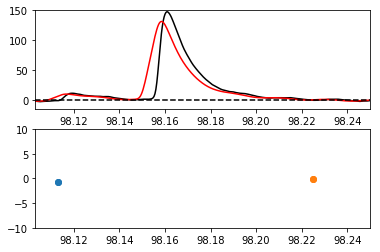

In [35]:
plt.subplot(211)
plt.plot(time,datos, 'k')
plt.plot(time[0:len(workingData)],workingData, 'r')
plt.plot(time, np.zeros(len(time)), 'k--')
#plt.plot(time[extremos[:,0]],datos[extremos[:,0]], 'o')
#plt.plot(time[extremos[:,1]],datos[extremos[:,1]], 'o')
#plt.plot(time[foot.astype('int')], datos[foot.astype('int')], 'o')
plt.xlim(98.103,98.25)
#plt.axis('off')
plt.ylim(-15,150)

plt.subplot(212)
plt.plot(time[extremos[:,0]],datos[extremos[:,0]], 'o')
plt.plot(time[extremos[:,1]],datos[extremos[:,1]], 'o')
plt.plot(time[foot.astype('int')], datos[foot.astype('int')], 'o')
plt.xlim(98.103,98.25)
plt.ylim(-10,10)
plt.show()

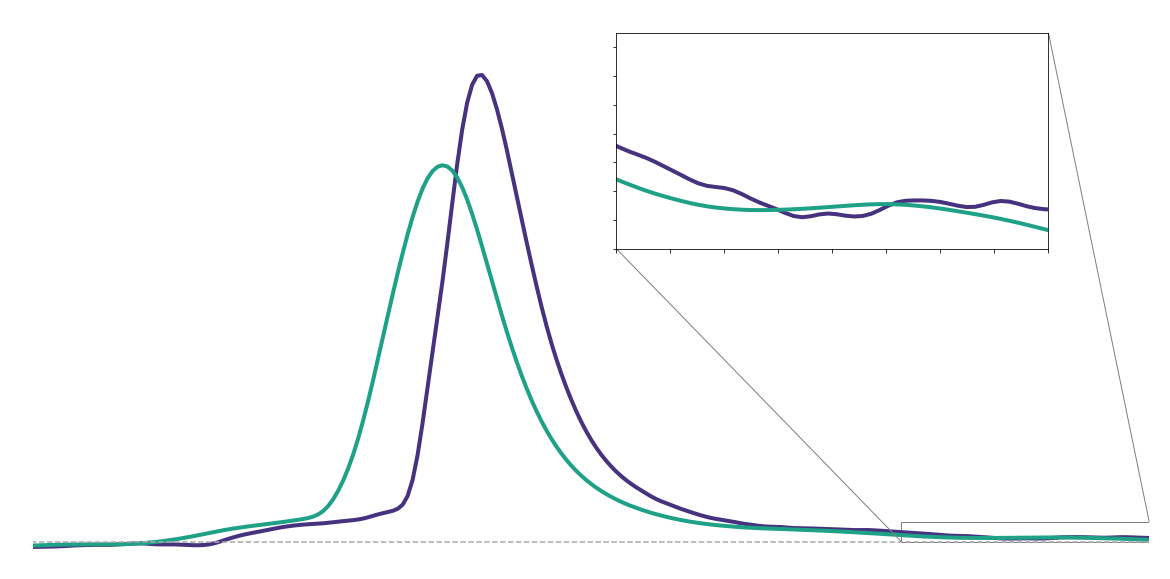

In [156]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax1 = plt.subplots(figsize=(20, 10))

color = [(0.27519100000000002, 0.19490499999999999, 0.49600499999999997),
 (0.212395, 0.35968299999999997, 0.55171000000000003),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.63315299999999997, 0.53039800000000004),
 (0.28892099999999998, 0.75839400000000001, 0.42842599999999997),
 (0.626579, 0.85464499999999999, 0.223353)]
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.53, 0.55, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(time,datos, 'k', color=color[0], lw=4)
ax1.plot(time[0:len(workingData)],workingData, color=color[3], lw=4)
ax1.plot(time, np.zeros(len(time)), '--', color='darkgrey')
#plt.plot(time[extremos[:,0]],datos[extremos[:,0]], 'o')
#plt.plot(time[extremos[:,1]],datos[extremos[:,1]], 'o')
#plt.plot(time[foot.astype('int')], datos[foot.astype('int')], 'o')
ax1.set_xlim(49.05,49.14)
ax1.set_ylim(-10,400)
ax1.axis('off')


ax2.plot(time,datos, 'k', color=color[0], lw=4)
ax2.plot(time[0:len(workingData)],workingData, color=color[3], lw=4)
ax2.set_xlim(49.12,49.14)
ax2.set_ylim(0,15)
#ax2.axis('off')
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec="0.5")

plt.yticks(visible=False)
plt.xticks(visible=False)
plt.show()

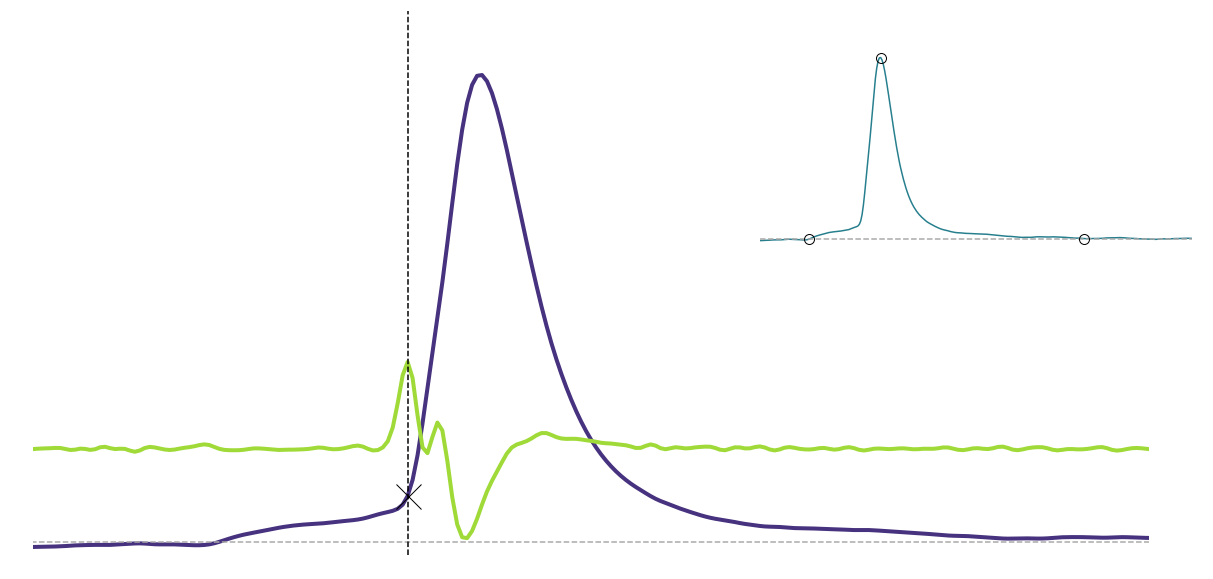

In [145]:
d2v = np.diff(wave,n=2)
fig, ax1 = plt.subplots(figsize=(20, 10))

color = [(0.27519100000000002, 0.19490499999999999, 0.49600499999999997),
 (0.212395, 0.35968299999999997, 0.55171000000000003),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.63315299999999997, 0.53039800000000004),
 (0.28892099999999998, 0.75839400000000001, 0.42842599999999997),
 (0.626579, 0.85464499999999999, 0.223353)]

left, bottom, width, height = [0.63, 0.55, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(time,datos, 'k', color=color[0], lw=4)
ax1.plot(time, np.zeros(len(time)), '--', color='darkgrey')
ax1.plot(time[0:len(d2v)], 10*d2v + 70, color=color[5], lw=4)

ax1.axvline(time[foot[82].astype('int')], ls = '--', color = 'black')
ax1.plot(time[foot.astype('int')], datos[foot.astype('int')], 
        marker = 'x', markersize = 25, color = 'black', linestyle='', markerfacecolor='None')
ax1.set_xlim(49.05,49.14)
ax1.set_ylim(-10,400)
ax1.axis('off')


ax2.plot(time,datos, 'k', color=color[2])
ax2.plot(time, np.zeros(len(time)), '--', color='darkgrey')
ax2.plot(time[extremos[:,0]],datos[extremos[:,0]], 
         marker = 'o', markersize = 10, color = 'black', linestyle='', markerfacecolor='None')
ax2.plot(time[extremos[:,1]],datos[extremos[:,1]], 
        marker = 'o', markersize = 10, color = 'black', linestyle='', markerfacecolor='None')
ax2.plot(time[peaks.astype('int')],datos[peaks.astype('int')], 
        marker = 'o', markersize = 10, color = 'black', linestyle='', markerfacecolor='None')

ax2.set_xlim(49.05,49.18)
ax2.set_ylim(-20,400)
ax2.axis('off')

plt.show()

In [38]:
cleaned = np.zeros(len(datos))
for i in range(len(inicio)):
    init = inicio[i]
    end = final[i]
    cleaned[init:end] = datos[init:end]

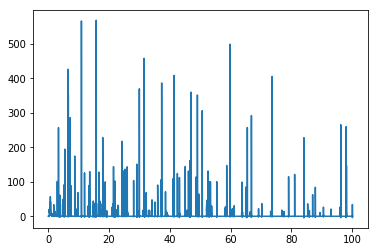

In [39]:
plt.plot(time,cleaned)
plt.show()

In [41]:
spike_points = np.zeros((len(inicio),2))
spike_points[:,0] = inicio.astype('int')
spike_points[:,1] = final.astype('int')
spike_points= spike_points.astype('int')
np.savetxt(filePackage+'-init_end.csv',spike_points, delimiter=',') 

In [42]:
spike_points= spike_points.astype('int')

In [43]:
recording = np.zeros((len(datos),2))
recording[:,0] = time
recording[:,1] = datos
np.savetxt(filePackage+'-recording.csv',recording, delimiter=',') 

In [106]:
t_s = time[peaks.astype('int')]
ISI = np.diff(t_s)
np.median(ISI)

0.47300188823109046

In [78]:
signal = datos[inicio[82]:final[82]]
s_time = time[inicio[82]:final[82]]

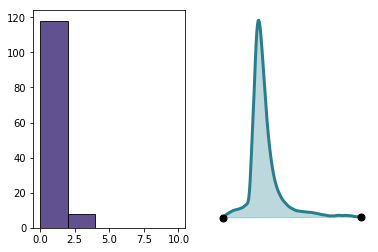

In [112]:
plt.subplot(1,2,1)
plt.hist(ISI, bins = [0,2,4,6,8,10], color = color[0], alpha = 0.85, histtype='bar', ec='black')


plt.subplot(1,2,2)
plt.plot(s_time,signal, 'k', color=color[2], lw = 3)
plt.plot(time[inicio[82]],datos[inicio[82]], 
         marker = 'o', markersize = 7, color = 'black', linestyle='')
plt.plot(time[final[82]],datos[final[82]], 
        marker = 'o', markersize = 7, color = 'black', linestyle='')
plt.fill(s_time,signal, color = color[2], alpha = 0.3)
plt.axis('off')
plt.show()

In [141]:
time[final[82]]

49.14739619719041